# Counting Objects as a Regression Problem

In previous chapters, we framed most computer vision problems as classification tasks.

But not all vision problems are classification problems.

In this notebook, we explore a different formulation:

> Counting objects in an image using regression.

Instead of:
- Detecting each object
- Drawing bounding boxes
- Performing segmentation

We directly predict a single number: the object count.

This simplified approach mirrors real-world systems like:
- Crowd counting
- Cell counting in microscopy
- Vehicle counting in traffic analysis

We will:
1. Generate a synthetic dataset of images with random circles
2. Train a CNN to predict object counts
3. Evaluate regression performance
4. Discuss how this relates to density estimation methods

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
import random

print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.9.1


In [2]:
# Generate Synthetic Counting Dataset

IMG_SIZE = 64
NUM_SAMPLES = 1000
MAX_OBJECTS = 5

def generate_image():
    image = np.zeros((IMG_SIZE, IMG_SIZE, 3), dtype=np.float32)
    count = random.randint(0, MAX_OBJECTS)
    
    for _ in range(count):
        x = random.randint(5, IMG_SIZE - 5)
        y = random.randint(5, IMG_SIZE - 5)
        radius = random.randint(3, 6)
        color = np.random.rand(3)

        yy, xx = np.ogrid[:IMG_SIZE, :IMG_SIZE]
        mask = (xx - x) ** 2 + (yy - y) ** 2 <= radius ** 2
        image[mask] = color
    
    return image, count

images = []
counts = []

for _ in range(NUM_SAMPLES):
    img, cnt = generate_image()
    images.append(img)
    counts.append(cnt)

images = np.array(images)
counts = np.array(counts, dtype=np.float32)

print("Dataset shape:", images.shape)


Dataset shape: (1000, 64, 64, 3)


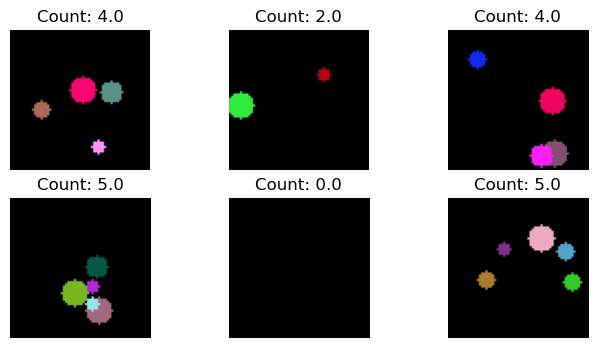

In [3]:
# Visualize Samples

plt.figure(figsize=(8,4))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(images[i])
    plt.title(f"Count: {counts[i]}")
    plt.axis("off")
plt.show()


In [4]:
# Train/Test Split

split = int(0.8 * NUM_SAMPLES)

x_train, x_val = images[:split], images[split:]
y_train, y_val = counts[:split], counts[split:]


In [5]:
# Build Regression CNN

model = tf.keras.Sequential([
    layers.Conv2D(16, 3, activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.GlobalAveragePooling2D(),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)  # Regression output
])

model.compile(
    optimizer="adam",
    loss="mse",
    metrics=["mae"]
)

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 64)        18496     
                                                                 
 global_average_pooling2d (G  (None, 64)               0

In [6]:
# Train

history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=10,
    batch_size=32
)


Epoch 1/10
25/25 [==============================] - 1s 22ms/step - loss: 4.5197 - mae: 1.6275 - val_loss: 0.9627 - val_mae: 0.8336
Epoch 2/10
25/25 [==============================] - 0s 12ms/step - loss: 1.0288 - mae: 0.8270 - val_loss: 0.7704 - val_mae: 0.7223
Epoch 3/10
25/25 [==============================] - 0s 12ms/step - loss: 0.8061 - mae: 0.7333 - val_loss: 0.7457 - val_mae: 0.6975
Epoch 4/10
25/25 [==============================] - 0s 12ms/step - loss: 0.7954 - mae: 0.7154 - val_loss: 0.7285 - val_mae: 0.6857
Epoch 5/10
25/25 [==============================] - 0s 12ms/step - loss: 0.7842 - mae: 0.7115 - val_loss: 0.7140 - val_mae: 0.6787
Epoch 6/10
25/25 [==============================] - 0s 12ms/step - loss: 0.7665 - mae: 0.7029 - val_loss: 0.7094 - val_mae: 0.6694
Epoch 7/10
25/25 [==============================] - 0s 12ms/step - loss: 0.7632 - mae: 0.7054 - val_loss: 0.7331 - val_mae: 0.6731
Epoch 8/10
25/25 [==============================] - 0s 12ms/step - loss: 0.7533 - m

In [7]:
# Evaluate

val_loss, val_mae = model.evaluate(x_val, y_val)
print("Validation MAE:", val_mae)


7/7 [==============================] - 0s 3ms/step - loss: 0.6282 - mae: 0.6417
Validation MAE: 0.6417496204376221


## Reflection

We solved counting using regression.

Key idea:
We did not detect individual objects —
we directly predicted the count.

In real-world crowd-counting systems,
models often predict *density maps* instead of bounding boxes.

Counting is not classification.
It is a different problem formulation over image data.
